# Workforce Capacity Planning — Multi‑Location Service Operations

This notebook generates synthetic multi‑location service demand, forecasts the next 8 weeks, and derives workforce capacity needs with utilization and buffer assumptions. It mirrors the methodology summarized in the accompanying PDF report.

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime
np.random.seed(42)

## 1) Generate synthetic daily demand

In [ ]:
import pandas as pd
start_date = pd.to_datetime("2025-02-03")
weeks_hist = 26
locations = ["Palo Alto","Fremont","San Jose","Dublin","Mountain View"]
dates = pd.date_range(start_date, periods=weeks_hist*7, freq="D")
base = {"Palo Alto":85,"Fremont":70,"San Jose":90,"Dublin":60,"Mountain View":65}
dow_mult = {"Monday":1.0,"Tuesday":1.05,"Wednesday":1.10,"Thursday":1.08,"Friday":0.95,"Saturday":0.70,"Sunday":0.55}
rows = []
for loc in locations:
    for d in dates:
        w = ((d - start_date).days)//7
        trend = 1 + 0.004*w
        mult = dow_mult[d.day_name()]
        noise = np.random.normal(0,6)
        promo = 1.15 if (np.random.rand()<0.05 and d.weekday() in [1,2]) else 1.0
        demand = max(0, base[loc]*trend*mult*promo + noise)
        rows.append({"date":d,"location":loc,"appointments":round(demand,0)})
raw = pd.DataFrame(rows)
raw.head()

,date,location,appointments
0,2025-02-03,Palo Alto,88.0
1,2025-02-04,Palo Alto,88.0
2,2025-02-05,Palo Alto,92.0
3,2025-02-06,Palo Alto,90.0
4,2025-02-07,Palo Alto,90.0


## 2) Weekly aggregation

In [ ]:
raw["week"] = raw["date"] - pd.to_timedelta(raw["date"].dt.weekday, unit="D")
weekly = raw.groupby(["location","week"],as_index=False)["appointments"].sum().sort_values(["location","week"])
weekly.head()

,location,week,appointments
0,Dublin,2025-02-03,369.0
1,Dublin,2025-02-10,417.0
2,Dublin,2025-02-17,375.0
3,Dublin,2025-02-24,378.0
4,Dublin,2025-03-03,385.0


## 3) Forecast next 8 weeks per location

In [ ]:
h=8
use_es = True
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
except Exception:
    use_es = False

fc_list = []
for loc in locations:
    s = weekly[weekly["location"]==loc].set_index("week")["appointments"]
    if use_es and len(s)>=12:
        try:
            model = ExponentialSmoothing(s, trend='add', seasonal=None, initialization_method="estimated")
            fit = model.fit(optimized=True); fc = fit.forecast(h)
        except Exception:
            last = s.rolling(4, min_periods=1).mean().iloc[-1]
            fc = pd.Series([last]*h, index=pd.date_range(s.index[-1]+pd.Timedelta(weeks=1), periods=h, freq="W-MON"))
    else:
        last = s.rolling(4, min_periods=1).mean().iloc[-1]
        fc = pd.Series([last]*h, index=pd.date_range(s.index[-1]+pd.Timedelta(weeks=1), periods=h, freq="W-MON"))
    fc_list.append(pd.DataFrame({"location":loc,"week":fc.index,"forecast_appointments":fc.values}))
forecast = pd.concat(fc_list).reset_index(drop=True)
forecast.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

,location,week,forecast_appointments
0,Palo Alto,2025-08-04,603.892305
1,Palo Alto,2025-08-11,606.006835
2,Palo Alto,2025-08-18,608.121365
3,Palo Alto,2025-08-25,610.235895
4,Palo Alto,2025-09-01,612.350424


## 4) Capacity model assumptions & calculation

In [ ]:
APPTS_PER_TECH_PER_WEEK = 30
UTIL = 0.85
BUFFER = 1.10
forecast["buffered_demand"] = forecast["forecast_appointments"] * BUFFER
forecast["weekly_capacity_per_tech"] = APPTS_PER_TECH_PER_WEEK * UTIL
forecast["required_techs"] = np.ceil(forecast["buffered_demand"] / forecast["weekly_capacity_per_tech"])

cap_summary = forecast.groupby("location").agg(
    avg_weekly_demand=("forecast_appointments","mean"),
    peak_weekly_demand=("forecast_appointments","max"),
    avg_required_techs=("required_techs","mean"),
    peak_required_techs=("required_techs","max"),
).reset_index()
cap_summary

,location,avg_weekly_demand,peak_weekly_demand,avg_required_techs,peak_required_techs
0,Dublin,431.094875,435.635902,19.00,19.0
1,Fremont,498.530451,503.636266,22.00,22.0
2,Mountain View,470.499646,476.897762,21.00,21.0
3,Palo Alto,611.293159,618.694014,27.00,27.0
4,San Jose,666.258275,677.421178,29.25,30.0


## 5) Visualizations

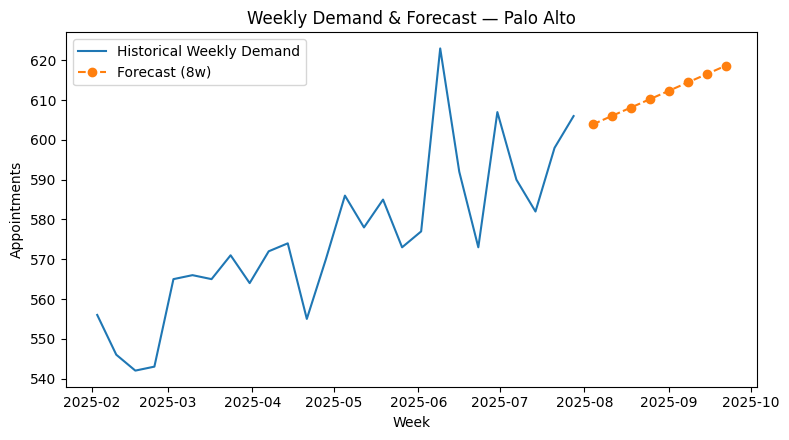

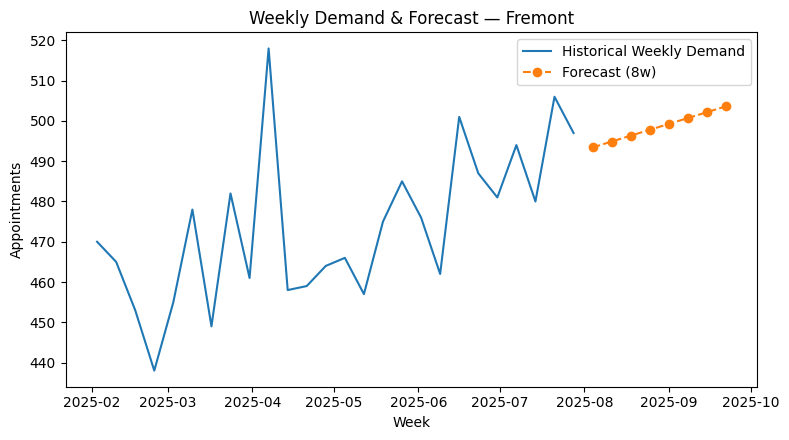

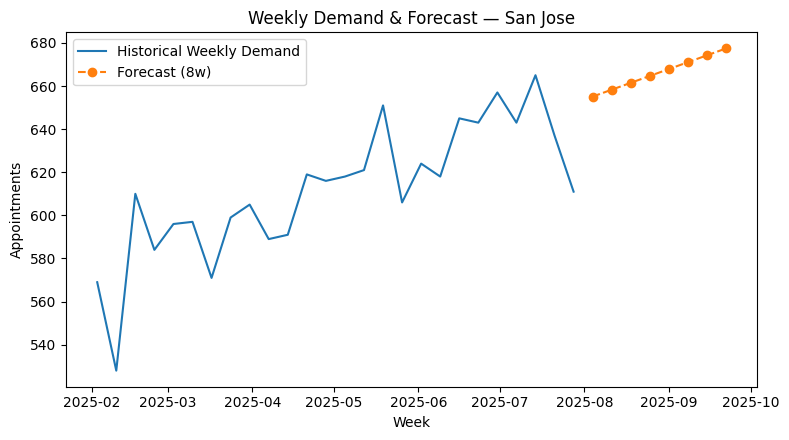

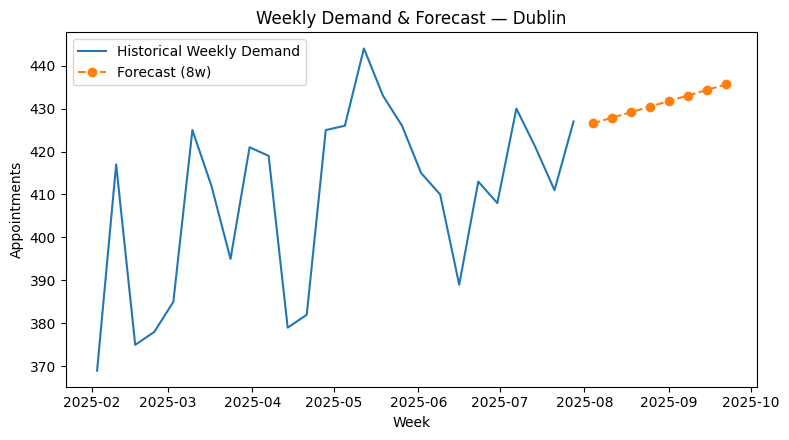

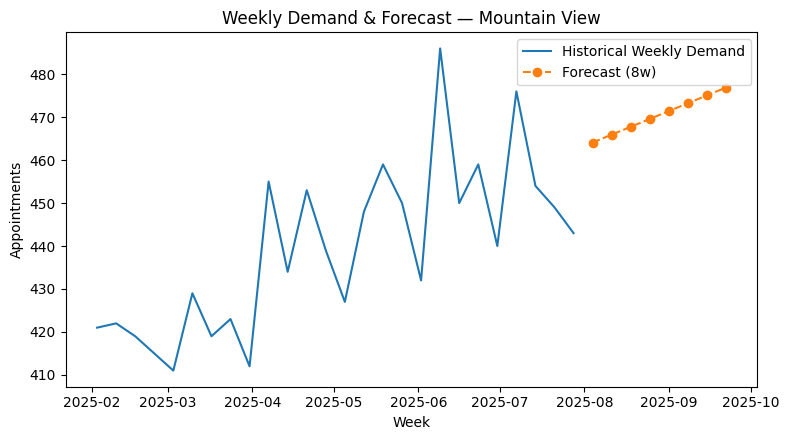

In [ ]:
import matplotlib.pyplot as plt
for loc in locations:
    hist = weekly[weekly["location"]==loc]
    fc = forecast[forecast["location"]==loc]
    plt.figure(figsize=(8,4.5))
    plt.plot(hist["week"], hist["appointments"], label="Historical Weekly Demand")
    plt.plot(fc["week"], fc["forecast_appointments"], linestyle="--", marker="o", label="Forecast (8w)")
    plt.title(f"Weekly Demand & Forecast — {loc}")
    plt.xlabel("Week"); plt.ylabel("Appointments"); plt.legend(); plt.tight_layout()
    plt.show()

## 6) Export tidy datasets

In [ ]:
import os
proj_out = "/content/ops_capacity_project/outputs"
os.makedirs(proj_out, exist_ok=True)
raw.to_csv(os.path.join(proj_out,"raw_daily_demand.csv"), index=False)
weekly.to_csv(os.path.join(proj_out,"weekly_demand.csv"), index=False)
forecast.to_csv(os.path.join(proj_out,"weekly_forecast_capacity.csv"), index=False)
cap_summary.to_csv(os.path.join(proj_out,"capacity_summary.csv"), index=False)
'exports written'

'exports written'